In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data

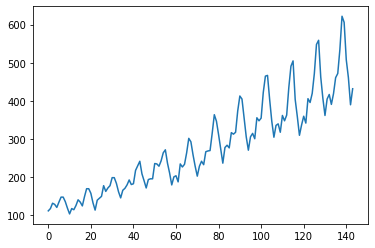

In [4]:
# load the dataset
dataframe = read_csv('Data/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [5]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

Input data Normalization

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### Splitting the data to train/test set
Since the data is a sequence of events we can't simply shuffle and split the data\
which potentially affect the forcasting/predition process\
instead we can split the data into 2/3 of sequential data for training and 1/3 for testing

In [7]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#### Preprocessing the data for forcasting purpose
in order use a simple ANN for time series forcasting,\ 
we can use a seq_size of the time series an input and the next point in the time series as output\
and build a regression model that given seq_size of previous data, predict the next point in the sequennce

In [ ]:
seq_size = 20 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
# trainX, trainY = to_sequences(train, seq_size)
# testX, testY = to_sequences(test, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

# print("Shape of training set: {}".format(trainX.shape))
# print("Shape of test set: {}".format(testX.shape))

#### Using Keras for ML Input generation

In [9]:
batch_size = 1
train_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55

Total number of samples in the original training data =  95
Total number of samples in the generated data =  75


In [10]:
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)

Build feed forward NN model...


In [11]:
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.fit(train_generator, verbose=2, epochs=100, validation_data=validation_generator)

Epoch 1/100
75/75 - 0s - loss: 2.5653e-04 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0345
Epoch 2/100
75/75 - 0s - loss: 2.1169e-04 - acc: 0.0000e+00 - val_loss: 0.0024 - val_acc: 0.0345
Epoch 3/100
75/75 - 0s - loss: 2.1829e-04 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0345
Epoch 4/100
75/75 - 0s - loss: 1.9890e-04 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0345
Epoch 5/100
75/75 - 0s - loss: 2.0962e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0345
Epoch 6/100
75/75 - 0s - loss: 2.1970e-04 - acc: 0.0000e+00 - val_loss: 0.0024 - val_acc: 0.0345
Epoch 7/100
75/75 - 0s - loss: 3.9023e-04 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0345
Epoch 8/100
75/75 - 0s - loss: 1.8590e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0345
Epoch 9/100
75/75 - 0s - loss: 2.2418e-04 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0345
Epoch 10/100
75/75 - 0s - loss: 1.7717e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0345
Epoch 11/100
75/75 - 0s - los

#### Make Model Prediction
After Traing the model, we can Predict/Forcast the rest of the data (Val/test sets)\
We can use Minimax Inverse Transform to scale back the peredicted the data

In [13]:
trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)

#### Calculating the RMSE for the train/test set

In [14]:
trainScore = math.sqrt(mean_squared_error(trainY_inverse[seq_size:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[seq_size:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.19 RMSE
Test Score: 19.45 RMSE


#### Plotting the test/train predicted data along with actual data

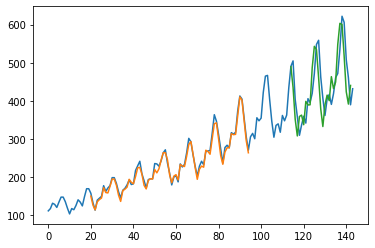

In [15]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train)+(seq_size)-1:len(dataset)-1, :] = testPredict


plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()